# Construcción del Grafo Poblacional de Costa Rica a nivel Distrital
Este cuaderno carga datos geoespaciales y poblacionales para construir un grafo de distritos contiguos con sus respectivas poblaciones como peso nodal.

In [9]:
!pip install geopandas shapely networkx pandas matplotlib openpyxl scikit-learn


  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   - -------------------------------------- 0.5/10.7 MB 4.2 MB/s eta 0:00:03
   --------- ------------------------------ 2.6/10.7 MB 8.9 MB/s eta 0:00:01
   --------------------- ------------------ 5.8/10.7 MB 12.2 MB/s eta 0:00:01
   --------------------------------- ------ 8.9/10.7 MB 12.9 MB/s eta 0:00:01
   ---------------------------------------- 10.7/10.7 MB 12.8 MB/s eta 0:00:00
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
   ---------------------------------------- 0.0/38.4 MB ? eta -:--:--
   ---- ----------------------------------- 3.9/38.4 MB 21.3 MB/s eta 0:00:02
   ------ --------------------------------- 6.6/38.4 MB 15.5 MB/s eta 0:00:03
   ---------- ----------------------------- 9.7/38.4 MB 15.1 MB/s eta 0:00:02
   ------------- -------------------------- 12.8/38.4


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
# Librerías 
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import re
from IPython.display import display

In [11]:
# Cargar shapefile de distritos (UGED 2022)
# Tomado de: https://inec.cr/mapas-cartografia/unidad-geoestadistica-distrital-2022 

shapefile_path = "data/UGED_MGN_2022/UGED_MGN_2022.shp"
gdf_distritos = gpd.read_file(shapefile_path)
gdf_distritos = gdf_distritos[gdf_distritos.geometry.notnull()].copy()
gdf_distritos.set_crs(epsg=5367, inplace=True)  # CRS oficial de Costa Rica
gdf_distritos[['NOMB_UGED', 'COD_UGED', 'AREA_KM2']].head(15)

print(gdf_distritos.shape)

(492, 7)


In [12]:
# gdf_distritos

# Mostrar la tabla resultante
with pd.option_context('display.max_rows', None):
    display(gdf_distritos)

,ID,NOMB_UGEP,NOMB_UGEC,NOMB_UGED,COD_UGED,AREA_KM2,geometry
0,1,SAN JOSE,SAN JOSE,CARMEN,10101,1.50,"POLYGON ((492798.4 1099069.69, 492804.97 10990..."
1,2,SAN JOSE,SAN JOSE,MERCED,10102,2.30,"POLYGON ((491397.73 1099285.2, 491384.97 10991..."
2,3,SAN JOSE,SAN JOSE,HOSPITAL,10103,3.34,"POLYGON ((489133.52 1097516.62, 489126.81 1097..."
3,4,SAN JOSE,SAN JOSE,CATEDRAL,10104,2.41,"POLYGON ((491112.51 1096945.7, 491135.42 10970..."
4,5,SAN JOSE,SAN JOSE,ZAPOTE,10105,2.75,"POLYGON ((494118.53 1097561.81, 494122.73 1097..."
5,6,SAN JOSE,SAN JOSE,SAN FRANCISCO DE DOS RIOS,10106,2.66,"POLYGON ((494498.46 1094758.24, 494483.12 1094..."
6,7,SAN JOSE,SAN JOSE,URUCA,10107,8.43,"POLYGON ((490640.52 1099551.17, 490633.42 1099..."
7,8,SAN JOSE,SAN JOSE,MATA REDONDA,10108,3.62,"POLYGON ((489240.44 1098353.45, 489227.7 10982..."
8,9,SAN JOSE,SAN JOSE,PAVAS,10109,9.43,"POLYGON ((487932.27 1099627.79, 487928.44 1099..."
9,10,SAN JOSE,SAN JOSE,HATILLO,10110,4.37,"POLYGON ((489780.05 1095568.29, 489774.25 1095..."


In [13]:
# Recargar con el excel nuevo:
df_distritos = pd.read_excel("data/df_distritos.xlsx") # distritos poblacion de 2022

# # Eliminar columnas cuyo nombre comience con 'Unnamed'
df_distritos = df_distritos.loc[:, ~df_distritos.columns.str.startswith("Unnamed")]

df_distritos
# Mostrar la tabla resultante
# with pd.option_context('display.max_rows', None):
#     display(df_distritos)

,Codigo,Distrito,Total
0,10101,CARMEN,2946
1,10102,MERCED,15408
2,10103,HOSPITAL,24030
3,10104,CATEDRAL,15682
4,10105,ZAPOTE,21990
...,...,...,...
487,70601,GUACIMO,26152
488,70602,MERCEDES,2357
489,70603,POCORA,8494
490,70604,RIO JIMENEZ,11836


In [14]:
# # Datos estadísticos de los distritos
df_distritos["Total"].describe()

count      492.000000
mean     10659.150407
std      11346.219640
min         20.000000
25%       3114.250000
50%       6938.500000
75%      13221.500000
max      89531.000000
Name: Total, dtype: float64

## Información de los distritos

In [15]:
media = df_distritos["Total"].mean()
desviacion = df_distritos["Total"].std()
mediana = df_distritos["Total"].median()
minimo = df_distritos["Total"].min()
maximo = df_distritos["Total"].max()

print(f"Media: {media:,.0f}")
print(f"Desviación estándar: {desviacion:,.0f}")
print(f"Mediana: {mediana:,.0f}")
print(f"Mínimo: {minimo:,.0f}")
print(f"Máximo: {maximo:,.0f}")

Media: 10,659
Desviación estándar: 11,346
Mediana: 6,938
Mínimo: 20
Máximo: 89,531


In [16]:
# Localizar distrito con el valor máximo
distrito_max = df_distritos[df_distritos["Total"] == df_distritos["Total"].max()]
distrito_min = df_distritos[df_distritos["Total"] == df_distritos["Total"].min()]
print(distrito_max)
print(distrito_min)

   Codigo Distrito  Total
8   10109    PAVAS  89531
     Codigo       Distrito  Total
409   60110  ISLA DEL COCO     20


In [17]:
# Convertir a string y rellenar con ceros a la izquierda (5 dígitos)
df_distritos["Codigo"] = df_distritos["Codigo"].astype(str).str.zfill(5)

# Verificar primeros resultados
df_distritos

,Codigo,Distrito,Total
0,10101,CARMEN,2946
1,10102,MERCED,15408
2,10103,HOSPITAL,24030
3,10104,CATEDRAL,15682
4,10105,ZAPOTE,21990
...,...,...,...
487,70601,GUACIMO,26152
488,70602,MERCEDES,2357
489,70603,POCORA,8494
490,70604,RIO JIMENEZ,11836


In [18]:
# # Normalizar nombres para asegurar coincidencias
# gdf_distritos["COD_UGED_clean"] = gdf_distritos["COD_UGED"].str.strip().str.upper()
# df_distritos["Codigo_clean"] = df_distritos["Codigo"].str.strip().str.upper()


# Unir por nombres limpios
gdf = gdf_distritos.merge(df_distritos, left_on="COD_UGED", right_on="Codigo", how="left")
# gdf = df_poblacion.merge(gdf_distritos, left_on="Nombre_clean", right_on="NOMB_UGED_clean", how="left")
gdf = gdf.dropna(subset=["Total"])


gdf = gdf.drop('Codigo', axis=1)
gdf = gdf.drop('Distrito', axis=1)
gdf = gdf.set_index("COD_UGED")


gdf

,ID,NOMB_UGEP,NOMB_UGEC,NOMB_UGED,AREA_KM2,geometry,Total
COD_UGED,,,,,,,
10101,1,SAN JOSE,SAN JOSE,CARMEN,1.50,"POLYGON ((492798.4 1099069.69, 492804.97 10990...",2946
10102,2,SAN JOSE,SAN JOSE,MERCED,2.30,"POLYGON ((491397.73 1099285.2, 491384.97 10991...",15408
10103,3,SAN JOSE,SAN JOSE,HOSPITAL,3.34,"POLYGON ((489133.52 1097516.62, 489126.81 1097...",24030
10104,4,SAN JOSE,SAN JOSE,CATEDRAL,2.41,"POLYGON ((491112.51 1096945.7, 491135.42 10970...",15682
10105,5,SAN JOSE,SAN JOSE,ZAPOTE,2.75,"POLYGON ((494118.53 1097561.81, 494122.73 1097...",21990
...,...,...,...,...,...,...,...
70601,488,LIMON,GUACIMO,GUACIMO,223.21,"POLYGON ((541495.33 1137601.46, 541493.37 1137...",26152
70602,489,LIMON,GUACIMO,MERCEDES,90.30,"POLYGON ((545964.81 1131691.9, 545955.03 11316...",2357
70603,490,LIMON,GUACIMO,POCORA,73.97,"POLYGON ((549791.93 1130646.89, 549789.41 1130...",8494


### 3. Índice de Polsby-Popper (Compacidad)
Este índice mide cuán compacto es un distrito según su forma geométrica. El valor ideal es cercano a 1 (circular).

$$
\text{Polsby-Popper} = \frac{4\pi \cdot A}{P^2}
$$

donde:

- $A$ es el área del distrito,
- $P$ es el perímetro del distrito.

Este índice toma valores en el intervalo $[0,1]$, siendo **1** la forma más compacta (un círculo perfecto).


In [19]:
def polsby_popper(geom):
    if geom and geom.area > 0 and geom.length > 0:
        return (4 * np.pi * geom.area) / (geom.length ** 2)
    return 0

gdf['polsby_popper'] = gdf.geometry.apply(polsby_popper)
# gdf[['NOMB_UGED', 'polsby_popper']].sort_values(by='polsby_popper', ascending=True).head(100)

gdf

,ID,NOMB_UGEP,NOMB_UGEC,NOMB_UGED,AREA_KM2,geometry,Total,polsby_popper
COD_UGED,,,,,,,,
10101,1,SAN JOSE,SAN JOSE,CARMEN,1.50,"POLYGON ((492798.4 1099069.69, 492804.97 10990...",2946,0.514917
10102,2,SAN JOSE,SAN JOSE,MERCED,2.30,"POLYGON ((491397.73 1099285.2, 491384.97 10991...",15408,0.349236
10103,3,SAN JOSE,SAN JOSE,HOSPITAL,3.34,"POLYGON ((489133.52 1097516.62, 489126.81 1097...",24030,0.558835
10104,4,SAN JOSE,SAN JOSE,CATEDRAL,2.41,"POLYGON ((491112.51 1096945.7, 491135.42 10970...",15682,0.457425
10105,5,SAN JOSE,SAN JOSE,ZAPOTE,2.75,"POLYGON ((494118.53 1097561.81, 494122.73 1097...",21990,0.408377
...,...,...,...,...,...,...,...,...
70601,488,LIMON,GUACIMO,GUACIMO,223.21,"POLYGON ((541495.33 1137601.46, 541493.37 1137...",26152,0.243852
70602,489,LIMON,GUACIMO,MERCEDES,90.30,"POLYGON ((545964.81 1131691.9, 545955.03 11316...",2357,0.242333
70603,490,LIMON,GUACIMO,POCORA,73.97,"POLYGON ((549791.93 1130646.89, 549789.41 1130...",8494,0.131558


In [20]:
gdf['polsby_popper'].describe()

count    492.000000
mean       0.294366
std        0.104659
min        0.033021
25%        0.218512
50%        0.288784
75%        0.354891
max        0.779809
Name: polsby_popper, dtype: float64

In [21]:
# Localizar distrito con el valor máximo y minimo polsby_popper
distrito_PP_max = gdf[gdf["polsby_popper"] == gdf["polsby_popper"].max()]
distrito_PP_min = gdf[gdf["polsby_popper"] == gdf["polsby_popper"].min()]
print(distrito_PP_max["NOMB_UGED"])
print(distrito_PP_min["NOMB_UGED"])

COD_UGED
20201    SAN RAMON
Name: NOMB_UGED, dtype: object
COD_UGED
50801    TILARAN
Name: NOMB_UGED, dtype: object


## Distritación por Provincias


# Alajuela

In [22]:
# Filtrar filas donde NOMB_UGEP sea 'Alajuela'
gdf_alajuela = gdf[gdf["NOMB_UGEP"] == "ALAJUELA"].copy()
# # Restaurar el índice si es necesario
# gdf_alajuela = gdf_alajuela.set_index("COD_UGED")

gdf_alajuela

,ID,NOMB_UGEP,NOMB_UGEC,NOMB_UGED,AREA_KM2,geometry,Total,polsby_popper
COD_UGED,,,,,,,,
20101,124,ALAJUELA,ALAJUELA,ALAJUELA,10.34,"POLYGON ((480147.73 1111451.82, 480146.54 1111...",48326,0.263205
20102,125,ALAJUELA,ALAJUELA,SAN JOSE,14.70,"POLYGON ((476283.46 1108224.58, 476281.03 1108...",52686,0.321395
20103,126,ALAJUELA,ALAJUELA,CARRIZAL,16.54,"POLYGON ((478735.64 1111888.64, 478742.3 11118...",9002,0.246998
20104,127,ALAJUELA,ALAJUELA,SAN ANTONIO,8.71,"POLYGON ((469262.36 1102201.35, 469255.48 1102...",31637,0.210224
20105,128,ALAJUELA,ALAJUELA,GUACIMA,29.23,"POLYGON ((478941.18 1105679.38, 478933.29 1105...",26642,0.193349
...,...,...,...,...,...,...,...,...
21503,235,ALAJUELA,GUATUSO,COTE,185.33,"POLYGON ((410844.39 1175688.72, 410843.17 1175...",1092,0.391677
21504,236,ALAJUELA,GUATUSO,KATIRA,125.98,"POLYGON ((404938.02 1194983.74, 404960.94 1194...",6497,0.234686
21601,237,ALAJUELA,RIO CUARTO,RIO CUARTO,102.64,"POLYGON ((480190.54 1145180.69, 480190.45 1145...",4562,0.253512


In [23]:
# Datos por distrito:

media = gdf_alajuela["Total"].mean()
desviacion = gdf_alajuela["Total"].std()
mediana = gdf_alajuela["Total"].median()
minimo = gdf_alajuela["Total"].min()
maximo = gdf_alajuela["Total"].max()

print(f"Media: {media:,.0f}")
print(f"Desviación estándar: {desviacion:,.0f}")
print(f"Mediana: {mediana:,.0f}")
print(f"Mínimo: {minimo:,.0f}")
print(f"Máximo: {maximo:,.0f}")

Media: 9,125
Desviación estándar: 9,619
Mediana: 5,709
Mínimo: 380
Máximo: 52,686


In [24]:
# Datos por Canton:

# Paso 1: sumar la población total por cantón
poblacion_por_canton = gdf_alajuela.groupby('NOMB_UGEC')['Total'].sum()

# Paso 2: calcular estadísticas sobre las poblaciones cantonales
media = poblacion_por_canton.mean()
desviacion = poblacion_por_canton.std()
mediana = poblacion_por_canton.median()
minimo = poblacion_por_canton.min()
maximo = poblacion_por_canton.max()

# Mostrar resultados
print(f"Media: {media:,.0f}")
print(f"Desviación estándar: {desviacion:,.0f}")
print(f"Mediana: {mediana:,.0f}")
print(f"Mínimo: {minimo:,.0f}")
print(f"Máximo: {maximo:,.0f}")


Media: 66,157
Desviación estándar: 83,743
Mediana: 35,057
Mínimo: 7,276
Máximo: 321,872


In [25]:
# Crear grafo de contigüidad Alajuela
G_alajuela = nx.Graph()

# Agregar nodos con población
for idx, row in gdf_alajuela.iterrows():
    G_alajuela.add_node(idx, nombre=row['NOMB_UGED'], poblacion=row['Total'])

# Agregar aristas entre distritos contiguos
for i, geom in gdf_alajuela.geometry.items():
    vecinos = gdf_alajuela[gdf_alajuela.geometry.touches(geom)].index
    for v in vecinos:
        if not G_alajuela.has_edge(i, v):
            G_alajuela.add_edge(i, v)

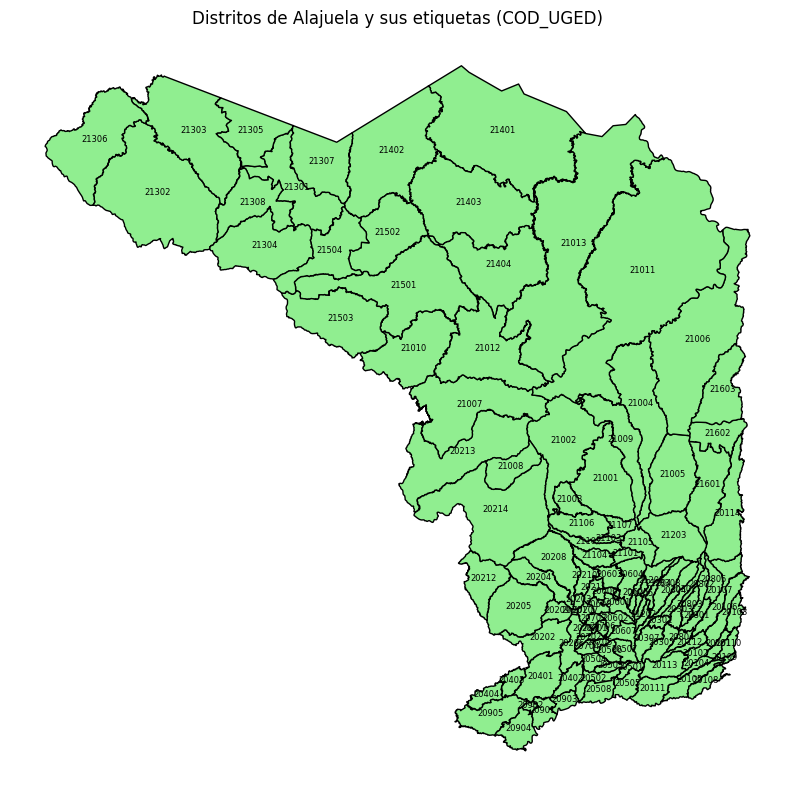

In [26]:
# Visualización del mapa
fig, ax = plt.subplots(figsize=(10, 10))
gdf_alajuela.plot(ax=ax, color='lightgreen', edgecolor='black')
for i, row in gdf_alajuela.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(i), fontsize=6, ha='center')
plt.title('Distritos de Alajuela y sus etiquetas (COD_UGED)')
plt.axis('off')
plt.show()

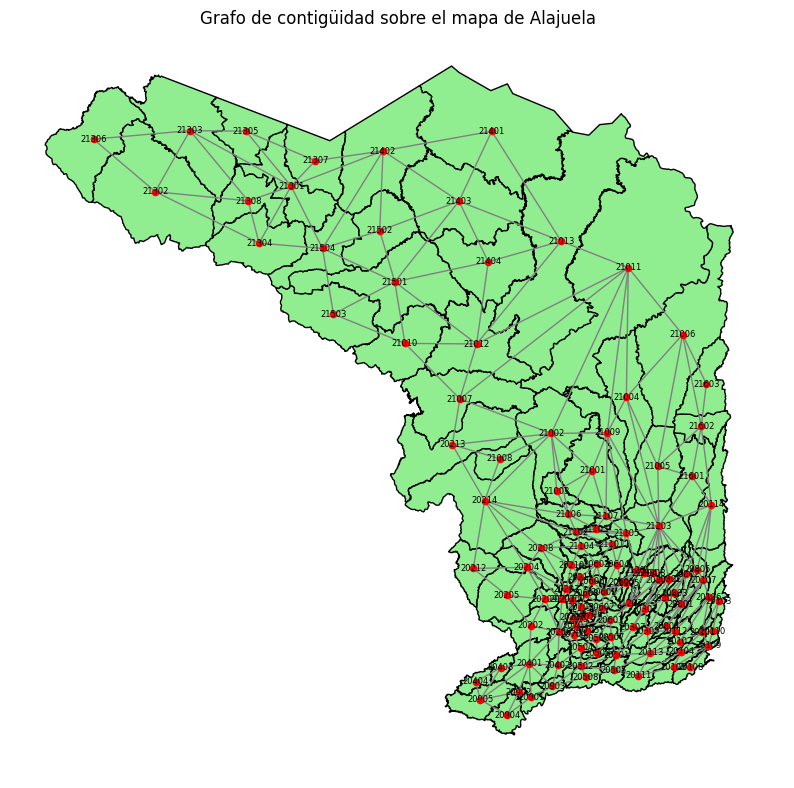

In [27]:
# Obtener posición geográfica de cada nodo desde los centroides
pos_geo_alajuela = {i: (geom.centroid.x, geom.centroid.y) for i, geom in gdf_alajuela.geometry.items()}

# Crear figura con base geográfica
fig, ax = plt.subplots(figsize=(10, 10))
gdf_alajuela.plot(ax=ax, color='lightgreen', edgecolor='black')

# Dibujar el grafo con posiciones geográficas
nx.draw(
    G_alajuela,
    pos=pos_geo_alajuela,
    ax=ax,
    node_size=20,
    node_color='red',
    edge_color='gray',
    with_labels=False  # Si quieres etiquetas usa: with_labels=True
)

# Añadir etiquetas opcionales
for i, (x, y) in pos_geo_alajuela.items():
    ax.text(x, y, str(i), fontsize=6, ha='center', va='center', color='black')

plt.title("Grafo de contigüidad sobre el mapa de Alajuela")
plt.axis('off')
plt.show()

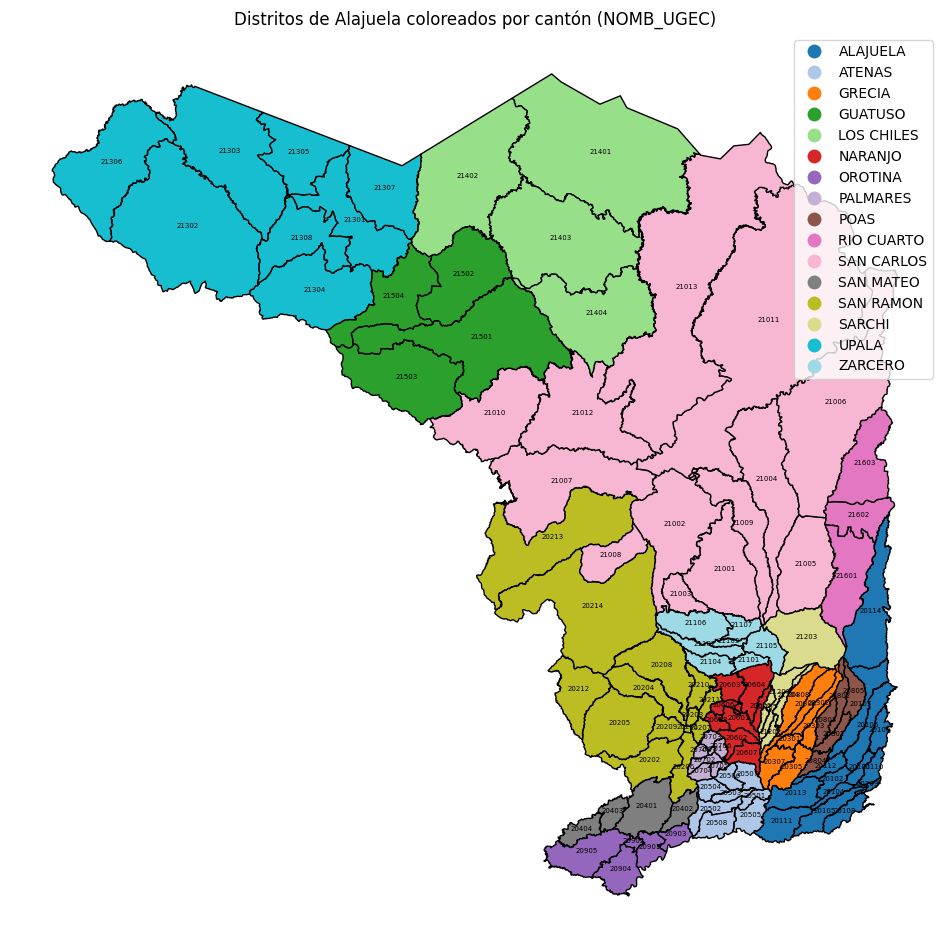

In [28]:
# Visualización del mapa con colores por cantón
fig, ax = plt.subplots(figsize=(12, 12))
gdf_alajuela.plot(
    ax=ax,
    column='NOMB_UGEC',       # columna con el nombre del cantón
    categorical=True,
    cmap='tab20',             # puede cambiarse a 'Set3', 'tab10', etc.
    edgecolor='black',
    legend=True
)

# Agregar etiquetas con el índice (u otra columna si se prefiere)
for i, row in gdf_alajuela.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(i), fontsize=5, ha='center')

plt.title('Distritos de Alajuela coloreados por cantón (NOMB_UGEC)')
plt.axis('off')
plt.show()

In [29]:
# Paso 1: Estimar número óptimo de distritos uninominales
poblacion_total_al = gdf_alajuela['Total'].sum()
print(poblacion_total_al)

meta_poblacional = 90000  # objetivo basado en diputados actuales

curules_al = poblacion_total_al/meta_poblacional

print(curules_al)


k_al = round(poblacion_total_al / meta_poblacional)
print(f'Número estimado de distritos (k): {k_al}')

1058505
11.761166666666666
Número estimado de distritos (k): 12


In [30]:
# Calcular centroides y extraer coordenadas
gdf_alajuela["centroid"] = gdf_alajuela.geometry.centroid
gdf_alajuela["x"] = gdf_alajuela["centroid"].x
gdf_alajuela["y"] = gdf_alajuela["centroid"].y

<Axes: >

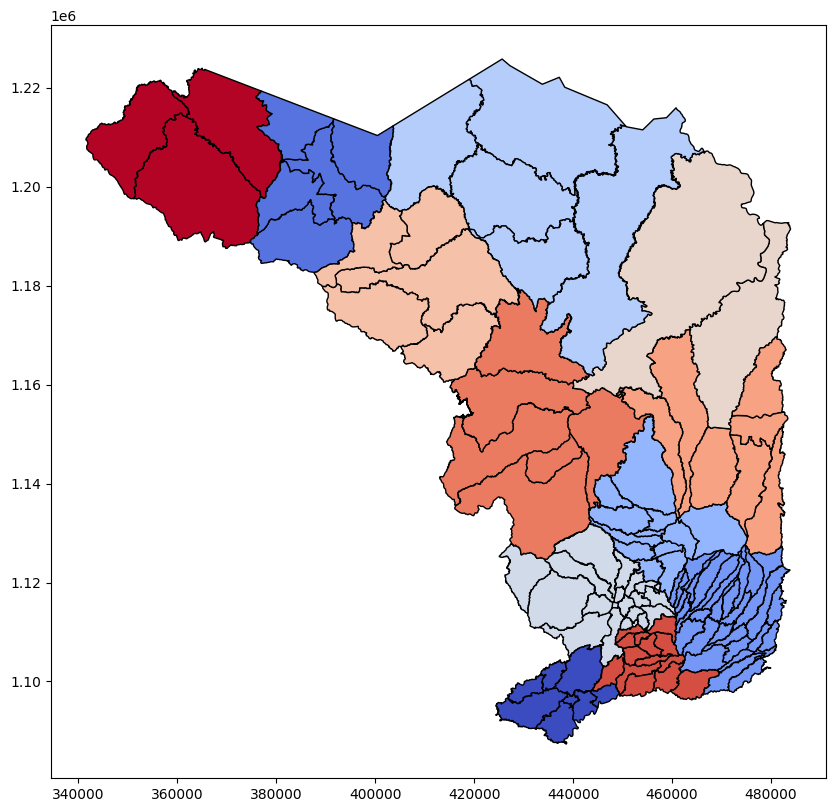

In [32]:
# Paso 2: Aplicar K-means usando coordenadas geográficas
# from sklearn.cluster import KMeans

coords = gdf_alajuela[['x', 'y']].values
kmeans = KMeans(n_clusters=k_al, random_state=0, n_init=10).fit(coords)
gdf_alajuela['DistritoNuevo'] = kmeans.labels_

gdf_alajuela.plot(column='DistritoNuevo', categorical=True, figsize=(10,10), legend=False, edgecolor='k', cmap='coolwarm')

In [33]:
# Paso 3: Evaluar población por nuevo distrito
agrupado_al = gdf_alajuela.groupby('DistritoNuevo')['Total'].agg(['count', 'sum']).rename(columns={'count': 'NumDistritos', 'sum': 'Poblacion'})
agrupado_al['Desviacion_%'] = 100 * (agrupado_al['Poblacion'] - meta_poblacional) / meta_poblacional
agrupado_al.sort_values(by='Poblacion')

,NumDistritos,Poblacion,Desviacion_%
DistritoNuevo,,,
11,3,18526,-79.415556
7,5,21869,-75.701111
0,8,30523,-66.085556
1,5,36940,-58.955556
6,2,40896,-54.560000
4,5,54884,-39.017778
10,14,60805,-32.438889
8,7,64770,-28.033333
9,6,67803,-24.663333


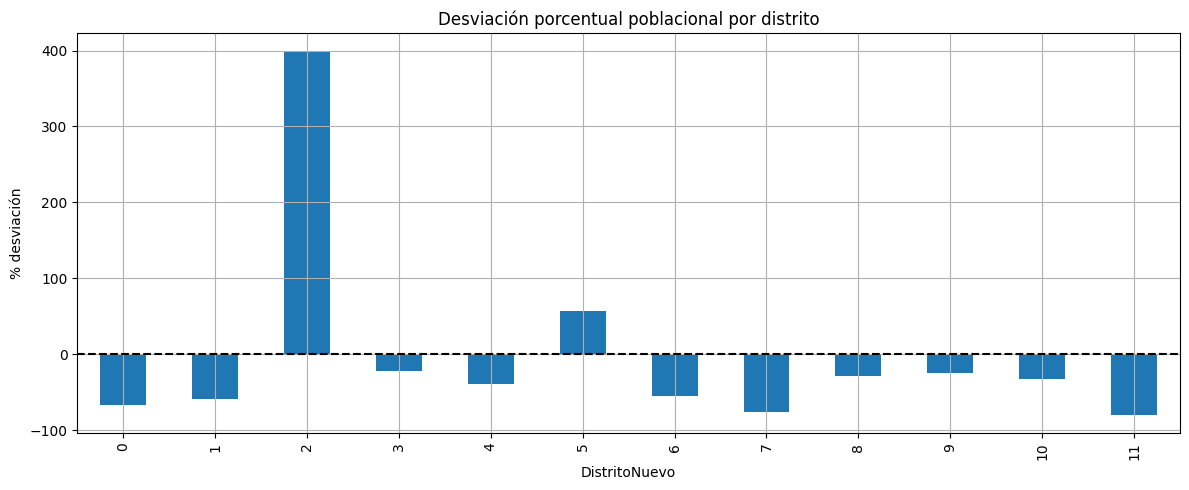

In [34]:
# Paso 4: Visualización de desviación poblacional

agrupado_al['Desviacion_%'].plot(kind='bar', figsize=(12,5), title='Desviación porcentual poblacional por distrito')
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('% desviación')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Paso 1: Crear matriz de adyacencia ponderada por proximidad y población
# from sklearn.preprocessing import normalize
# from sklearn.cluster import SpectralClustering
# import numpy as np
# import networkx as nx

gdf_alajuelaS = gdf_alajuela.reset_index(drop=True)


G_alS = nx.Graph()
G_alS.add_nodes_from(gdf_alajuelaS.index)
for i, geom_i in gdf_alajuelaS.geometry.items():
    for j, geom_j in gdf_alajuelaS.geometry.items():
        if i < j and geom_i.touches(geom_j):
            pop_diff = abs(gdf_alajuelaS.loc[i, 'Total'] - gdf_alajuelaS.loc[j, 'Total']) + 1
            weight = 1 / pop_diff
            G_alS.add_edge(i, j, weight=weight)

mat_Al = nx.to_numpy_array(G_alS, nodelist=gdf_alajuelaS.index, weight='weight')

In [36]:
# Paso 2: Aplicar Clustering Espectral
spectral_al = SpectralClustering(n_clusters=k_al, affinity='precomputed', assign_labels='kmeans', random_state=0)
gdf_alajuelaS['Distrito_Spectral'] = spectral_al.fit_predict(mat_Al)


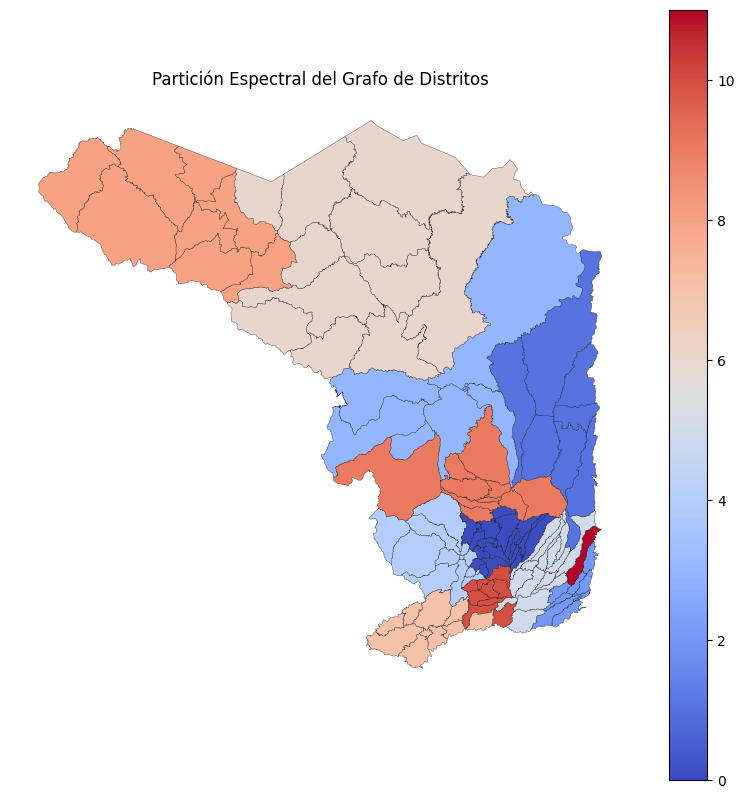

In [37]:
# Visualización del resultado
# import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
gdf_alajuelaS.plot(column='Distrito_Spectral', cmap='coolwarm', linewidth=0.2, edgecolor='black', ax=ax, legend=True)
plt.title('Partición Espectral del Grafo de Distritos')
plt.axis('off')
plt.show()

In [38]:
# import pandas as pd
# import numpy as np
# from IPython.display import display

# Paso 1: Sumar población total por nuevo distrito
poblacion_distritos = gdf_alajuelaS.groupby('Distrito_Spectral')['Total'].sum()

# Paso 2: Calcular población ideal (promedio)
poblacion_total = poblacion_distritos.sum()
num_distritos = poblacion_distritos.size
poblacion_ideal = poblacion_total / num_distritos

print(poblacion_total)
print(num_distritos)
print(poblacion_ideal)

1058505
12
88208.75


In [39]:
# Paso 3: Calcular desviación absoluta y relativa
desviaciones = pd.DataFrame({
    'Poblacion': poblacion_distritos,
    'Desviacion_Absoluta': poblacion_distritos - poblacion_ideal,
    'Desviacion_Relativa_%': 100 * (poblacion_distritos - poblacion_ideal) / poblacion_ideal
})

# Paso 4: Métricas agregadas
desviacion_max = desviaciones['Desviacion_Relativa_%'].abs().max()
std_dev = desviaciones['Desviacion_Relativa_%'].std()
cv = std_dev / 100  # Coeficiente de variación (en proporción)

# Mostrar tabla
display(desviaciones)

# Mostrar métricas agregadas
print(f"Población total: {poblacion_total}")
print(f"Población ideal por distrito: {poblacion_ideal:.2f}")
print(f"Desviación máxima relativa: {desviacion_max:.2f}%")
print(f"Desviación estándar relativa: {std_dev:.2f}%")
print(f"Coeficiente de variación: {cv:.4f}")

,Poblacion,Desviacion_Absoluta,Desviacion_Relativa_%
Distrito_Spectral,,,
0,103615,15406.25,17.465671
1,85240,-2968.75,-3.365596
2,249690,161481.25,183.067156
3,81913,-6295.75,-7.137330
4,96534,8325.25,9.438123
5,156119,67910.25,76.988111
6,78706,-9502.75,-10.773024
7,32743,-55465.75,-62.880100
8,57834,-30374.75,-34.435076


Población total: 1058505
Población ideal por distrito: 88208.75
Desviación máxima relativa: 183.07%
Desviación estándar relativa: 71.17%
Coeficiente de variación: 0.7117


## Evaluacion


In [40]:
meta_poblacional = gdf_alajuelaS['Total'].sum() / k_al
limite_inferior = 0.75 * meta_poblacional
limite_superior = 1.25 * meta_poblacional

# Sumar población por clúster
validacion = (
    gdf_alajuelaS.groupby('Distrito_Spectral')['Total']
    .sum()
    .reset_index()
    .rename(columns={'Total': 'Población_Distrito'})
)

# Agregar columnas de validación
validacion['Valido'] = validacion['Población_Distrito'].between(limite_inferior, limite_superior)

print(meta_poblacional)
print(validacion)



88208.75
    Distrito_Spectral  Población_Distrito  Valido
0                   0              103615    True
1                   1               85240    True
2                   2              249690   False
3                   3               81913    True
4                   4               96534    True
5                   5              156119   False
6                   6               78706    True
7                   7               32743   False
8                   8               57834   False
9                   9               62205   False
10                 10               31320   False
11                 11               22586   False


## Probemos enfoque de separar distritos 'grandes': 

In [41]:
meta_poblacional = gdf_alajuelaS['Total'].sum() / k_al
lim_inf = 0.75 * meta_poblacional
lim_sup = 1.25 * meta_poblacional


In [42]:
# Cantones demasiado grandes para agrupar
distritos_grandes = gdf_alajuelaS[gdf_alajuelaS['Total'] > 0.5*meta_poblacional].copy()
distritos_restantes = gdf_alajuelaS[gdf_alajuelaS['Total'] <= 0.5*meta_poblacional].copy()

print(distritos_grandes[['NOMB_UGED', 'Total']])

# print(distritos_restantes[['NOMB_UGED', 'Total']])



   NOMB_UGED  Total
0   ALAJUELA  48326
1   SAN JOSE  52686
72   QUESADA  46127


In [43]:
G_rest = nx.Graph()
G_rest.add_nodes_from(distritos_restantes.index)
for i, geom_i in distritos_restantes.geometry.items():
    for j, geom_j in distritos_restantes.geometry.items():
        if i < j and geom_i.touches(geom_j):
            pop_diff = abs(distritos_restantes.loc[i, 'Total'] - distritos_restantes.loc[j, 'Total']) + 1
            weight = 1 / pop_diff
            G_rest.add_edge(i, j, weight=weight)

mat_rest = nx.to_numpy_array(G_rest, nodelist=distritos_restantes.index, weight='weight')


In [44]:
k_grandes = len(distritos_grandes)
k_restantes = k_al - k_grandes

print(k_restantes)

9


In [45]:
spectral_rest = SpectralClustering(n_clusters=k_restantes, affinity='precomputed',
                                    assign_labels='kmeans', random_state=0)
distritos_restantes['Distrito_Spectral'] = spectral_rest.fit_predict(mat_rest)


In [46]:
gdf_final = pd.concat([distritos_restantes, distritos_grandes]).sort_index()


In [44]:
# gdf_final

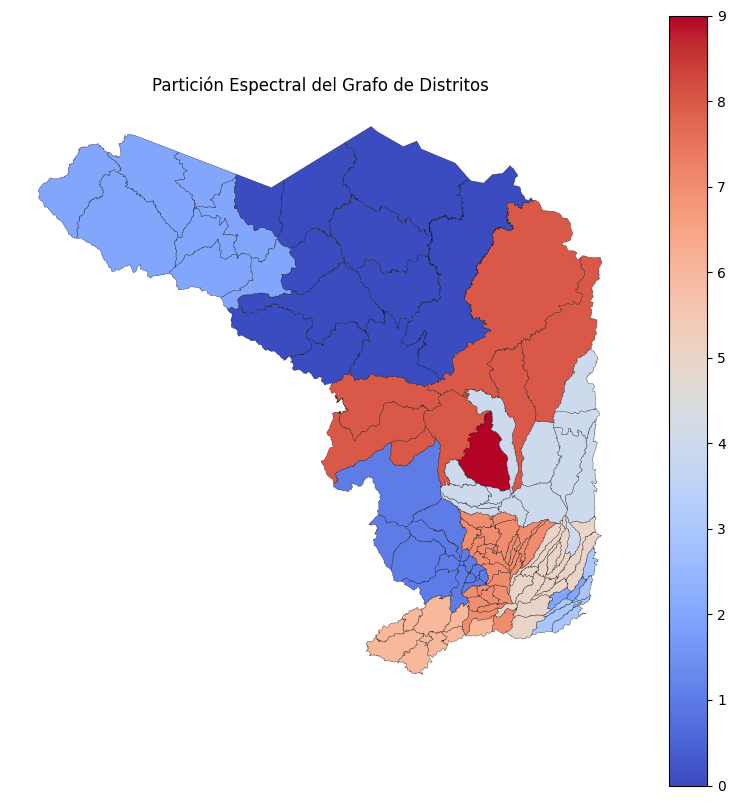

In [48]:
# Visualización del resultado
# import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
gdf_final.plot(column='Distrito_Spectral', cmap='coolwarm', linewidth=0.2, edgecolor='black', ax=ax, legend=True)
plt.title('Partición Espectral del Grafo de Distritos')
plt.axis('off')
plt.show()

In [49]:
# Validacion

# Sumar población por clúster
validacion = (
    gdf_final.groupby('Distrito_Spectral')['Total']
    .sum()
    .reset_index()
    .rename(columns={'Total': 'Población_Distrito'})
)

# Agregar columnas de validación
validacion['Valido'] = validacion['Población_Distrito'].between(limite_inferior, limite_superior)

print(meta_poblacional)
print(validacion)

88208.75
   Distrito_Spectral  Población_Distrito  Valido
0                  0               78706    True
1                  1              118946   False
2                  2              158846   False
3                  3              148678   False
4                  4               51121   False
5                  5              178705   False
6                  6               32743   False
7                  7              118996   False
8                  8              125637   False
9                  9               46127   False


## Generalizando

In [50]:
# from sklearn.cluster import SpectralClustering
# import numpy as np
# import networkx as nx
# import pandas as pd

def crear_distritos_con_restricciones(gdf, k_total, columna_poblacion, columna_geom,
                                       tolerancia, random_state):
    """
    Agrupa unidades geográficas en distritos electorales con restricciones de población.
    
    Parámetros:
    - gdf: GeoDataFrame con columnas de geometría y población
    - k_total: número total de distritos a crear
    - columna_poblacion: nombre de la columna con la población total
    - columna_geom: nombre de la columna con geometría
    - tolerancia: proporción de tolerancia (0.15 = ±15%)
    - random_state: semilla para reproducibilidad
    
    Retorna:
    - gdf_final: GeoDataFrame con columna 'Distrito_Spectral' asignada
    """
    gdf = gdf.reset_index(drop=True).copy()

    # Paso 1: Cálculo de meta poblacional y rangos
    poblacion_total = gdf[columna_poblacion].sum()
    meta = poblacion_total / k_total
    lim_inf = (1 - tolerancia) * meta
    lim_sup = (1 + tolerancia) * meta

    # Paso 2: Identificar unidades grandes que no pueden agruparse
    gdf_grandes = gdf[gdf[columna_poblacion] > lim_sup].copy()
    gdf_restantes = gdf[gdf[columna_poblacion] <= lim_sup].copy()

    k_grandes = len(gdf_grandes)
    k_restantes = k_total - k_grandes

    if k_restantes <= 0:
        raise ValueError("Número de unidades indivisibles excede o iguala el total de distritos solicitados.")

    # Paso 3: Crear grafo de adyacencia para las unidades restantes
    G = nx.Graph()
    G.add_nodes_from(gdf_restantes.index)

    for i, geom_i in gdf_restantes[columna_geom].items():
        for j, geom_j in gdf_restantes[columna_geom].items():
            if i < j and geom_i.touches(geom_j):
                pop_diff = abs(gdf_restantes.loc[i, columna_poblacion] - gdf_restantes.loc[j, columna_poblacion]) + 1
                weight = 1 / pop_diff
                G.add_edge(i, j, weight=weight)

    # Paso 4: Matriz de adyacencia y clustering espectral
    nodos = list(gdf_restantes.index)
    A = nx.to_numpy_array(G, nodelist=nodos, weight='weight')

    spectral = SpectralClustering(n_clusters=k_restantes, affinity='precomputed',
                                   assign_labels='kmeans', random_state=random_state)
    etiquetas_restantes = spectral.fit_predict(A)

    gdf_restantes['Distrito_Spectral'] = etiquetas_restantes

    # Paso 5: Asignar identificadores únicos a los cantones grandes
    gdf_grandes['Distrito_Spectral'] = range(k_restantes, k_total)

    # Paso 6: Combinar resultados y ordenar
    gdf_final = pd.concat([gdf_restantes, gdf_grandes], axis=0)
    gdf_final = gdf_final.sort_index()

    return gdf_final


In [51]:
crear_distritos_con_restricciones(gdf_alajuelaS, k_al, 'Total', 'geometry',
                                       0.25, 0)

,ID,NOMB_UGEP,NOMB_UGEC,NOMB_UGED,AREA_KM2,geometry,Total,polsby_popper,centroid,x,y,DistritoNuevo,Distrito_Spectral
0,124,ALAJUELA,ALAJUELA,ALAJUELA,10.34,"POLYGON ((480147.73 1111451.82, 480146.54 1111...",48326,0.263205,POINT (477526.994 1108672.864),477526.993613,1.108673e+06,2,2
1,125,ALAJUELA,ALAJUELA,SAN JOSE,14.70,"POLYGON ((476283.46 1108224.58, 476281.03 1108...",52686,0.321395,POINT (472909.767 1106663.689),472909.766876,1.106664e+06,2,2
2,126,ALAJUELA,ALAJUELA,CARRIZAL,16.54,"POLYGON ((478735.64 1111888.64, 478742.3 11118...",9002,0.246998,POINT (480897.705 1115002.907),480897.704856,1.115003e+06,2,2
3,127,ALAJUELA,ALAJUELA,SAN ANTONIO,8.71,"POLYGON ((469262.36 1102201.35, 469255.48 1102...",31637,0.210224,POINT (473196.309 1104558.827),473196.309058,1.104559e+06,2,2
4,128,ALAJUELA,ALAJUELA,GUACIMA,29.23,"POLYGON ((478941.18 1105679.38, 478933.29 1105...",26642,0.193349,POINT (471654.25 1101409.879),471654.250158,1.101410e+06,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,235,ALAJUELA,GUATUSO,COTE,185.33,"POLYGON ((410844.39 1175688.72, 410843.17 1175...",1092,0.391677,POINT (401220.718 1174427.877),401220.717889,1.174428e+06,7,6
112,236,ALAJUELA,GUATUSO,KATIRA,125.98,"POLYGON ((404938.02 1194983.74, 404960.94 1194...",6497,0.234686,POINT (398958.129 1188008.158),398958.129470,1.188008e+06,7,8
113,237,ALAJUELA,RIO CUARTO,RIO CUARTO,102.64,"POLYGON ((480190.54 1145180.69, 480190.45 1145...",4562,0.253512,POINT (475387.047 1140863.327),475387.046552,1.140863e+06,8,1
114,238,ALAJUELA,RIO CUARTO,SANTA RITA,53.76,"POLYGON ((472118.77 1153733.98, 472145.81 1153...",5704,0.355220,POINT (477321.083 1151218.624),477321.082747,1.151219e+06,8,1


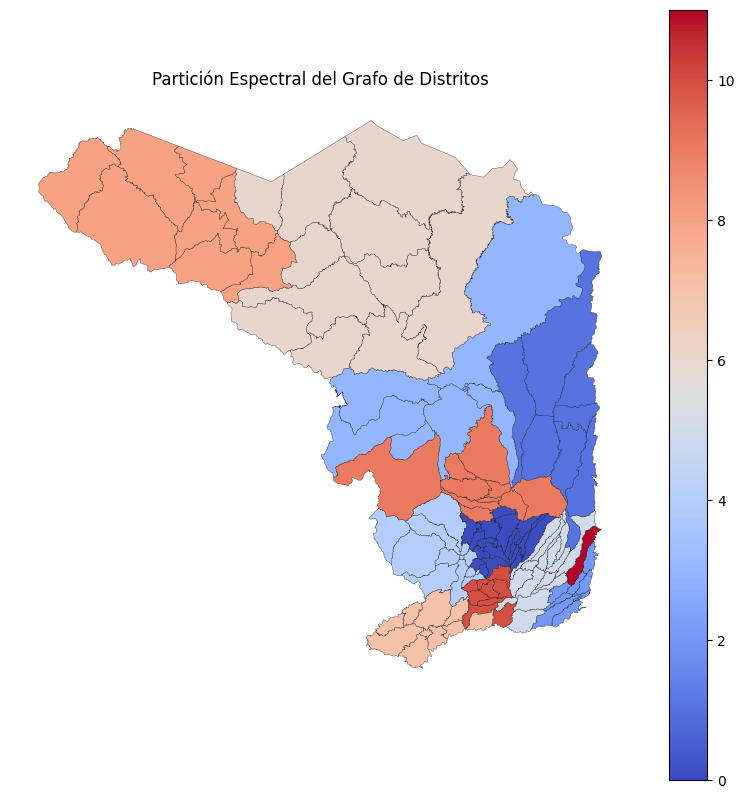

In [52]:
# Visualización del resultado
# import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
gdf_alajuelaS.plot(column='Distrito_Spectral', cmap='coolwarm', linewidth=0.2, edgecolor='black', ax=ax, legend=True)
plt.title('Partición Espectral del Grafo de Distritos')
plt.axis('off')
plt.show()

In [53]:
# Validacion

# Sumar población por clúster
validacion = (
    gdf_alajuelaS.groupby('Distrito_Spectral')['Total']
    .sum()
    .reset_index()
    .rename(columns={'Total': 'Población_Distrito'})
)

# Agregar columnas de validación
validacion['Valido'] = validacion['Población_Distrito'].between(limite_inferior, limite_superior)

print(meta_poblacional)
print(validacion)

88208.75
    Distrito_Spectral  Población_Distrito  Valido
0                   0              103615    True
1                   1               85240    True
2                   2              249690   False
3                   3               81913    True
4                   4               96534    True
5                   5              156119   False
6                   6               78706    True
7                   7               32743   False
8                   8               57834   False
9                   9               62205   False
10                 10               31320   False
11                 11               22586   False


## Mejoremos...


In [54]:
def clustering_validado_por_umbral(gdf, k_maximo, columna_poblacion='Total', columna_geom='geometry',
                                   tolerancia_baja=0.70, tolerancia_alta=0.90, random_state=0,
                                   max_reintentos=10):
    """
    Aplica SpectralClustering iterativo hasta encontrar una partición donde
    todos los clústeres estén en el rango [85%-125%] de la meta poblacional.
    """
    gdf = gdf.reset_index(drop=True).copy()
    total_poblacion = gdf[columna_poblacion].sum()
    meta = total_poblacion / k_maximo
    lim_inf = (1 - tolerancia_baja) * meta
    lim_sup = (1 + tolerancia_alta) * meta

    # Paso 1: Construcción del grafo de adyacencia
    G = nx.Graph()
    G.add_nodes_from(gdf.index)
    for i, geom_i in gdf[columna_geom].items():
        for j, geom_j in gdf[columna_geom].items():
            if i < j and geom_i.touches(geom_j):
                pop_diff = abs(gdf.loc[i, columna_poblacion] - gdf.loc[j, columna_poblacion]) + 1
                weight = 1 / pop_diff
                G.add_edge(i, j, weight=weight)

    nodos = list(gdf.index)
    A = nx.to_numpy_array(G, nodelist=nodos, weight='weight')

    # Paso 2: Intentar distintas particiones hasta que todas sean válidas
    for intento in range(max_reintentos):
        clustering = SpectralClustering(
            n_clusters=k_maximo, affinity='precomputed',
            assign_labels='kmeans', random_state=random_state + intento
        )
        labels = clustering.fit_predict(A)
        gdf['Distrito_Spectral'] = labels

        # Validar población por distrito
        poblacion_por_distrito = gdf.groupby('Distrito_Spectral')[columna_poblacion].sum()
        valido = poblacion_por_distrito.between(lim_inf, lim_sup).all()

        if valido:
            return gdf, meta, lim_inf, lim_sup

    # Si después de los intentos no hay éxito
    raise ValueError(f"No se logró una partición válida en {max_reintentos} intentos.")


In [55]:
gdf_valido, meta, lim_inf, lim_sup = clustering_validado_por_umbral(gdf_alajuelaS, k_maximo=k_al)

# # Visualización
# fig, ax = plt.subplots(figsize=(10, 10))
# gdf_valido.plot(column='Distrito_Spectral', cmap='tab20', linewidth=0.2, edgecolor='black', ax=ax, legend=True)
# plt.title('Distritos con validación iterativa (Spectral Clustering)')
# plt.axis('off')
# plt.show()

# Verificación
validacion = (
    gdf_valido.groupby('Distrito_Spectral')['Total']
    .sum()
    .reset_index()
    .rename(columns={'Total': 'Poblacion_Distrito'})
)
validacion['Valido'] = validacion['Poblacion_Distrito'].between(lim_inf, lim_sup)

print("Meta poblacional esperada:", round(meta, 2))
print(validacion)


Meta poblacional esperada: 88208.75
    Distrito_Spectral  Poblacion_Distrito  Valido
0                   0              127302    True
1                   1              156365    True
2                   2               74577    True
3                   3               82189    True
4                   4              159170    True
5                   5               65099    True
6                   6               79019    True
7                   7               38235    True
8                   8               61963    True
9                   9               26682    True
10                 10               71993    True
11                 11              115911    True


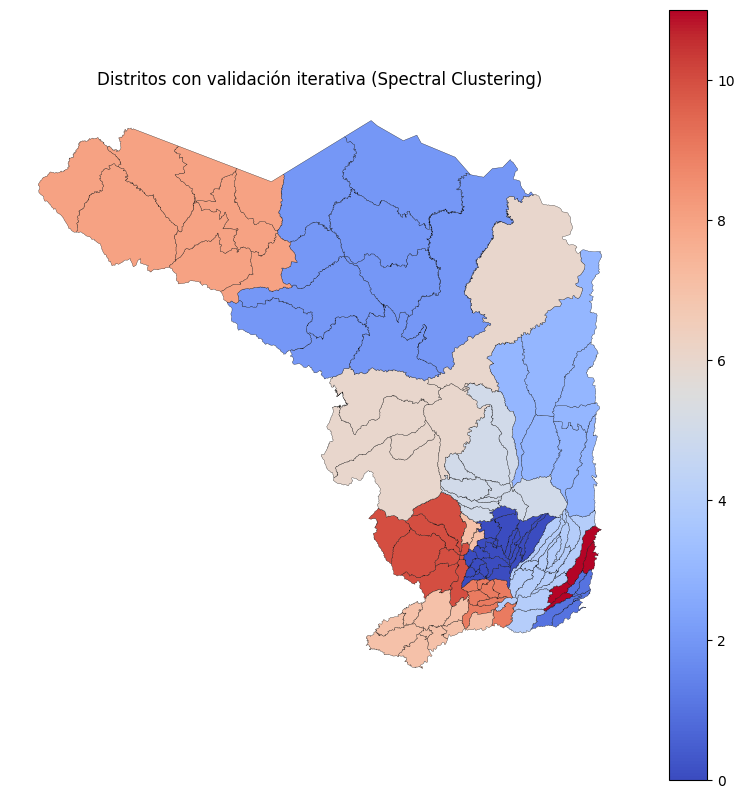

In [56]:
# Visualización
fig, ax = plt.subplots(figsize=(10, 10))
gdf_valido.plot(column='Distrito_Spectral', cmap='coolwarm', linewidth=0.2, edgecolor='black', ax=ax, legend=True)
plt.title('Distritos con validación iterativa (Spectral Clustering)')
plt.axis('off')
plt.show()

In [57]:
validacion

,Distrito_Spectral,Poblacion_Distrito,Valido
0,0,127302,True
1,1,156365,True
2,2,74577,True
3,3,82189,True
4,4,159170,True
5,5,65099,True
6,6,79019,True
7,7,38235,True
8,8,61963,True
9,9,26682,True


In [58]:
agrupado_al = validacion.groupby('Distrito_Spectral')['Poblacion_Distrito'].agg(['count', 'sum']).rename(columns={'count': 'Distrito_Spectral', 'sum': 'Poblacion_Distrito'})
agrupado_al['Desviacion_%'] = 100 * (agrupado_al['Poblacion_Distrito'] - meta_poblacional) / meta_poblacional
agrupado_al.sort_values(by='Poblacion_Distrito')

,Distrito_Spectral,Poblacion_Distrito,Desviacion_%
Distrito_Spectral,,,
9,1,26682,-69.751300
7,1,38235,-56.653960
8,1,61963,-29.754134
5,1,65099,-26.198932
10,1,71993,-18.383380
2,1,74577,-15.453966
6,1,79019,-10.418184
3,1,82189,-6.824436
11,1,115911,31.405331


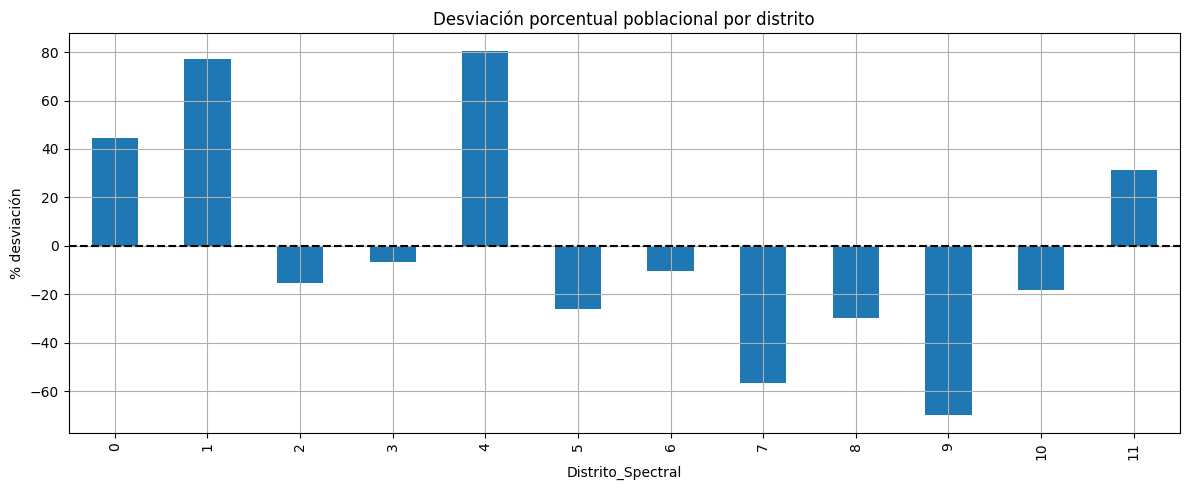

In [59]:
# Visualización de desviación poblacional

agrupado_al['Desviacion_%'].plot(kind='bar', figsize=(12,5), title='Desviación porcentual poblacional por distrito')
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('% desviación')
plt.grid(True)
plt.tight_layout()
plt.show()